In [2]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install ipwhois

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
columns = ['Type',
           'sflow_agent_address',
           'inputPort',
           'outputPort',
           'src_MAC',
           'dst_MAC',
           'ethernet_type',
           'in_vlan',
           'out_vlan',
           'src_IP',
           'dst_IP',
           'IP_protocol',
           'ip_tos',
           'ip_ttl',
           'udp_src_port/tcp_src_port/icmp_type',
           'udp_dst_port/tcp_dst_port/icmp_code',
           'tcp_flags',
           'packet_size',
           'IP_size',
           'sampling_rate'
           ]

In [6]:
df = pd.read_csv('Data_2.csv', names=columns, index_col=False, on_bad_lines="skip")

Organisation Name

In [7]:
from ipwhois import IPWhois
from ipwhois.exceptions import IPDefinedError

def get_organization_from_ip(ip_address):
    try:
        obj = IPWhois(ip_address)
        results = obj.lookup_rdap()
        # Prefer org name from entities if available
        return results.get('network', {}).get('name') or results.get('asn_description')
    except IPDefinedError:
        return "IP address is reserved or private"
    except Exception as e:
        return f"Error: {str(e)}"

EXERCISE 4A: TOP TALKERS AND LISTENERS

One of the most commonly used function in analyzing data log is finding out the IP address of the hosts that send out large amount of packet and hosts that receive large number of packets, usually know as TOP TALKERS and LISTENERS.  Based on the IP address we can obtained the organization who owns the IP address. 


Talkers

In [8]:
top_talkers = df['src_IP'].value_counts().head(5).to_frame().reset_index()
organization = []
for talker in top_talkers['src_IP']:
    organization.append(get_organization_from_ip(talker))
top_talkers['Organization'] = organization
top_talkers = top_talkers.rename(columns={'src_IP': 'IP Address', 'count': '# of packets'})
top_talkers

,IP Address,# of packets,Organization
0,13.107.4.50,5960,MSFT
1,130.14.250.7,4034,NLM-ETHER
2,155.69.160.38,3866,NTUNET1
3,171.67.77.19,2656,NETBLK-SUNET
4,155.69.199.255,2587,NTUNET1


Listeners

In [9]:
top_listeners = df['dst_IP'].value_counts().head(5).to_frame().reset_index()
organization = []
for listener in top_listeners['dst_IP']:
    organization.append(get_organization_from_ip(listener))
top_listeners['Organization'] = organization
top_listeners = top_listeners.rename(columns={'dst_IP': 'IP Address', 'count': '# of packets'})
top_listeners

,IP Address,# of packets,Organization
0,137.132.228.33,5908,NUSNET
1,192.122.131.36,4662,A-STAR-AS-AP
2,202.51.247.133,4288,NUSGP
3,137.132.228.29,4022,NUSNET
4,103.37.198.100,3741,A-STAR-AS-AP


EXERCISE 4B: TRANSPORT PROTOCOL
Using the IP protocol type attribute, determine the percentage of TCP and UDP protocol

In [14]:
packetdf = df['IP_protocol'].value_counts().head(5)

packetdf = df['IP_protocol'].value_counts().reset_index()
packetdf.columns = ['Header value', 'No. of Packets']

# Calculate percentage
packetdf['Percentage of Packets'] = packetdf['No. of Packets'] * 100 / len(df)

# Filter for TCP (6) and UDP (17)
finaldf = packetdf[packetdf['Header value'].isin([6, 17])]

print(packetdf)

print(finaldf)

   Header value  No. of Packets  Percentage of Packets
0             6          137707              77.698723
1            17           36852              20.793085
2             0            1216               0.686106
3            50             718               0.405119
4            47             664               0.374650
5             1              60               0.033854
6            58              10               0.005642
7            41               3               0.001693
8             2               2               0.001128
   Header value  No. of Packets  Percentage of Packets
0             6          137707              77.698723
1            17           36852              20.793085


EXERCISE 4C: APPLICATIONS PROTOCOL
Using the Destination IP port number determine the most frequently used application protocol. (For finding the service given the port number  https://www.adminsub.net/tcp-udp-port-finder/ )

In [26]:
dp_df = df['udp_dst_port/tcp_dst_port/icmp_code'].value_counts().head(5).reset_index().rename(columns=
                                                                                              {'udp_dst_port/tcp_dst_port/icmp_code': 'Destination IP port number', 'count': '# of packets'})
dp_df

,Destination IP port number,# of packets
0,443,43208
1,80,11018
2,50930,2450
3,15000,2103
4,8160,1354


EXERCISE 4D: TRAFFIC
The traffic intensity is an important parameter that a network engineer needs to monitor closely to determine if there is congestion. You would use the IP packet size to calculate the estimated total traffic over the monitored period of 15 seconds. (Assume the sampling rate is 1 in 2048)

In [27]:
# Step 1: Sum sampled packet sizes in bytes
total_size_sampled = df['IP_size'].sum()

# Step 2: Scale up to estimate total size (sampling rate: 1 in 2048)
total_size = total_size_sampled * 2048

# Step 3: Convert bytes to megabytes (1 MB = 2^20 bytes)
total_size_MB = total_size / (2**20)

# Step 4: Print the total estimated traffic in MB
print(f"Total estimated traffic over 15 seconds: {total_size_MB:.3f} MB")


Total estimated traffic over 15 seconds: 331903.809 MB


EXERCISE 4E: ADDITIONAL ANALYSIS
Please append ONE page to provide additional analysis of the data and the insight it provides. Examples include: Top 5 communication pairs; Visualization of communications between different IP hosts; etc.



In [28]:
comm_pairs_df= df.groupby(['src_IP', 'dst_IP']).size().sort_values(ascending=False).to_frame()

comm_pairs_df.columns = ['No. of Packets']
comm_pairs_df = comm_pairs_df.reset_index()

top_comm_df = comm_pairs_df[:5]
top_comm_df


,src_IP,dst_IP,No. of Packets
0,130.14.250.7,103.37.198.100,3739
1,171.67.77.19,192.122.131.36,2656
2,129.99.230.54,137.132.22.74,2097
3,137.132.228.42,137.131.17.212,1553
4,155.69.252.133,138.75.242.36,1475


In [29]:

# Apply the IP-to-org lookup for source and destination IPs
top_comm_df['Source Organisation'] = top_comm_df['src_IP'].apply(get_organization_from_ip)
top_comm_df['Destination Organisation'] = top_comm_df['dst_IP'].apply(get_organization_from_ip)

# Reorder and rename the columns as desired
top_comm_df = top_comm_df[[
    'src_IP', 'Source Organisation',
    'dst_IP', 'Destination Organisation',
    'No. of Packets'
]]

top_comm_df


C:\Users\mroha\AppData\Local\Temp\ipykernel_16560\2782971201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_comm_df['Source Organisation'] = top_comm_df['src_IP'].apply(get_organization_from_ip)
C:\Users\mroha\AppData\Local\Temp\ipykernel_16560\2782971201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_comm_df['Destination Organisation'] = top_comm_df['dst_IP'].apply(get_organization_from_ip)


,src_IP,Source Organisation,dst_IP,Destination Organisation,No. of Packets
0,130.14.250.7,NLM-ETHER,103.37.198.100,A-STAR-AS-AP,3739
1,171.67.77.19,NETBLK-SUNET,192.122.131.36,A-STAR-AS-AP,2656
2,129.99.230.54,NAS-NET,137.132.22.74,NUSNET,2097
3,137.132.228.42,NUSNET,137.131.17.212,ORACLE-4,1553
4,155.69.252.133,NTUNET1,138.75.242.36,M1LIMITED-SG,1475


The top 5 communication pairs reveal a mix of international research collaboration and commercial activity. The dominant flow from NLM-ETHER, USA represents scientific data exchange between the U.S. National Library of Medicine (a biomedical research institution) to Singapore’s Agency for Science A*STAR, Technology and Research. Other major pairs include traffic involving NUSNET, NTUNET, universities from Singapore suggesting academic workloads such as cloud-based research or e-learning. The presence of NAS-NET (a U.S. federal research network supporting NASA and scientific agencies), ORACLE-4 (a global enterprise cloud provider), and M1LIMITED-SG (a Singaporean telecommunications carrier) indicates that this exchange point supports not only academic collaboration but also commercial cloud services and national research infrastructure.
 

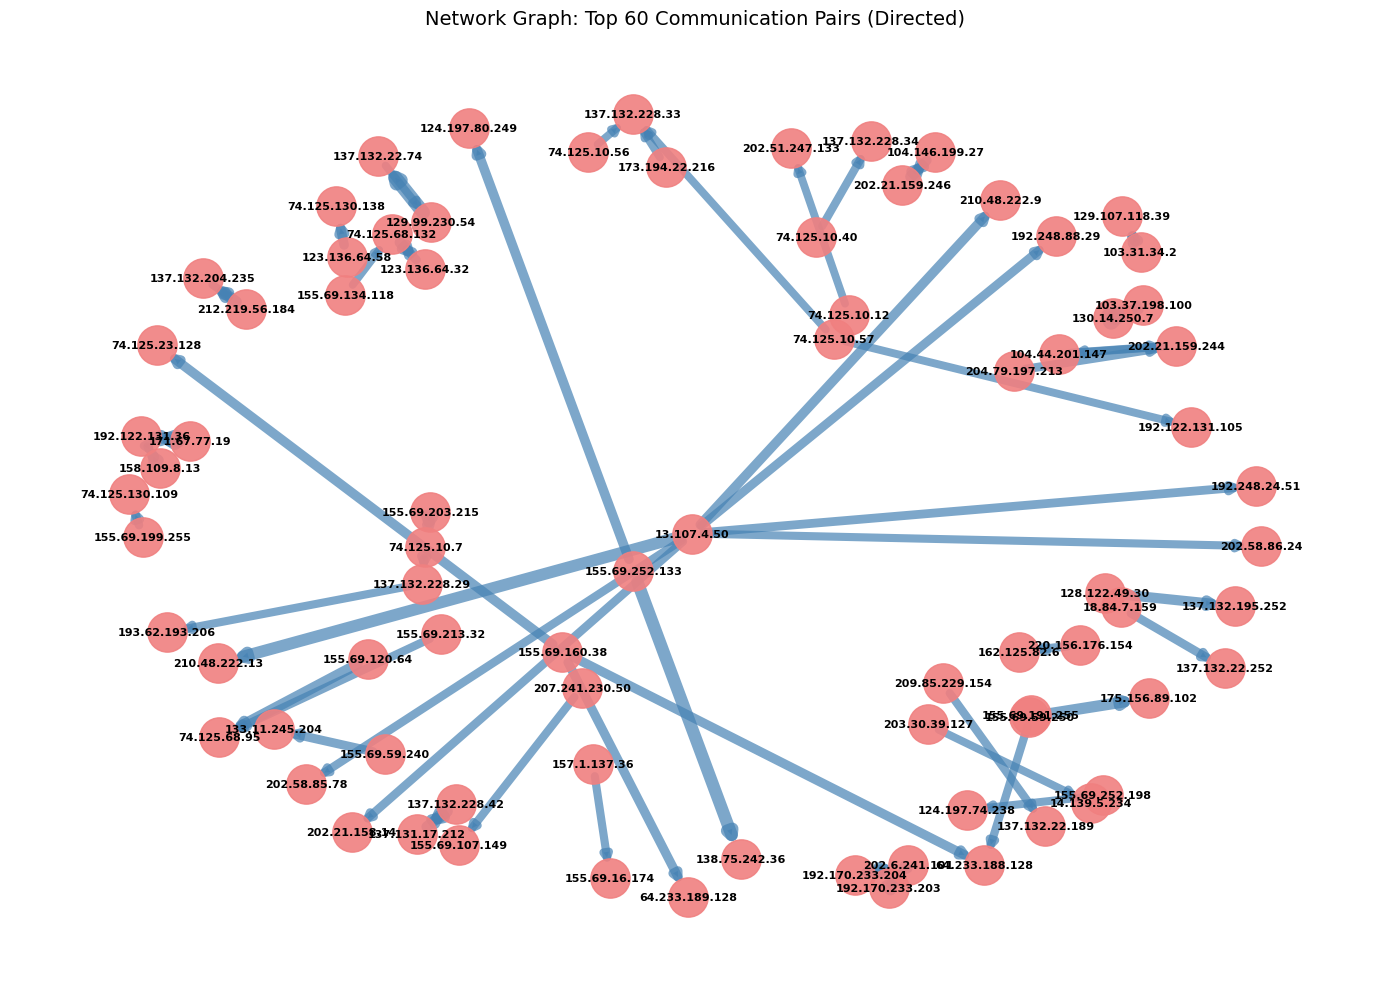

Graph includes 80 unique IPs and 60 directed flows.


In [32]:

comm_pairs_df = df.groupby(['src_IP', 'dst_IP']).size().reset_index(name='No. of Packets')
comm_pairs_df = comm_pairs_df.sort_values('No. of Packets', ascending=False)

# Use TOP 20 pairs for clarity and speed
top_pairs = comm_pairs_df.head(60)

# Build directed graph
G = nx.DiGraph()
for _, row in top_pairs.iterrows():
    G.add_edge(row['src_IP'], row['dst_IP'], weight=row['No. of Packets'])

# Use IP addresses directly as labels (FAST — no WHOIS needed for graph)
ip_to_label = {ip: ip for ip in set(top_pairs['src_IP'].tolist() + top_pairs['dst_IP'].tolist())}
nx.set_node_attributes(G, ip_to_label, 'label')

# Plot
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)  # Consistent layout

# Edge widths: scale with log(weight) for visibility
weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_widths = [max(w ** 0.3, 0.5) for w in weights]

nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='steelblue')
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightcoral', alpha=0.9)
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), 
                        font_size=8, font_weight='bold')

plt.title("Network Graph: Top 60 Communication Pairs (Directed)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig("network_graph_top60.png", dpi=300, bbox_inches='tight')
plt.show()

# Optional: Print summary
print(f"Graph includes {G.number_of_nodes()} unique IPs and {G.number_of_edges()} directed flows.")

The directed network graph of the top 60 communication pairs reveals a star-like topology centered around a dominant hub (155.69.252.133), which communicates with dozens of other hosts. This structure strongly suggests a centralized gateway or core server managing most network traffic. Smaller clusters around other IPs indicate localized communication groups, while the variation in edge direction and thickness reflects heterogeneous usage, ranging from high-volume unidirectional transfers to bidirectional exchanges,consistent with a dynamic academic and research-oriented network environment.